##High level insight on Wikipedia web traffic.

Note: If this helped you, some upvotes would be very much appreciated.

It is foolish to fear what we have yet to see and know ;) 

### Library and Settings
Import required library and define constants

In [1]:
%matplotlib inline
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import calendar

import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
# from bokeh.charts import TimeSeries, show

### File Size

In [2]:
for f in os.listdir('../input'):
    size_bytes = round(os.path.getsize('../input/' + f)/ 1000, 2)
    size_name = ["KB", "MB"]
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    print(f.ljust(25) + str(s).ljust(7) + size_name[i])

train_2.csv              397.43 MB
.DS_Store                6.0    KB
train_1.csv              271.5  MB
example-web-traffic-with-lstm.zip196.0  KB
sample_submission_2.csv  131.75 MB
key_2.csv                752.26 MB
sample_submission_1.csv  127.5  MB
key_1.csv                727.99 MB


In [3]:
train_df = pd.read_csv("../input/train_1.csv")
key_df = pd.read_csv("../input/key_1.csv")

In [4]:
print("Train".ljust(15), train_df.shape)
print("Key".ljust(15), key_df.shape)

('Train          ', (145063, 551))
('Key            ', (8703780, 2))


As we can see Train data frame is having less number of page details than number of mappings between keys and page. First and last rows of train and key data frame.

In [24]:
# print(train_df[:4].append(train_df[-4:], ignore_index=True))

In [25]:
# print(key_df[:4].append(key_df[-4:], ignore_index=True))

Each article name has the following format: 'name_project_access_agent' . That would be a good idea to separate out all these 4 features to get better understanding of data

In [5]:
page_details = pd.DataFrame([i.split("_")[-3:] for i in train_df["Page"]])
page_details.columns = ["project", "access", "agent"]
page_details.describe()
# print page_details

,project,access,agent
count,145063,145063,145063
unique,9,3,2
top,en.wikipedia.org,all-access,all-agents
freq,24108,74315,110150


As we can see there are 9, 3 and 2 unique values for project, access and agent respectively. Why not have quick look on these values

In [6]:
project_columns = page_details['project'].unique()
access_columns = page_details['access'].unique()
agents_columns = page_details['agent'].unique()
print(list(page_details['project'].unique()))
print(list(page_details['access'].unique()))
print(list(page_details['agent'].unique()))

['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org', 'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org', 'de.wikipedia.org', 'ja.wikipedia.org', 'es.wikipedia.org']
['all-access', 'desktop', 'mobile-web']
['spider', 'all-agents']


In [8]:
print train_df.shape

(145063, 551)


So no NA values in here. Perfect. Lets merge

In [9]:
train_df = page_details.merge(train_df, how="inner", left_index=True, right_index=True)

In [11]:
a= train_df.groupby('project').get_group('en.wikipedia.org')
print a.shape
b = a.groupby('agent').get_group('spider')
print b.shape
c = a.groupby('agent').get_group('all-agents')
print c.shape

(24108, 554)
(4931, 554)
(19177, 554)


Boom. Let's plot the project wise monthly mean hits.

In [32]:
def graph_by(plot_hue, graph_columns):
    train_project_df = train_df.groupby(plot_hue).sum().T
    train_project_df.index = pd.to_datetime(train_project_df.index)
    train_project_df = train_project_df.groupby(pd.TimeGrouper('M')).mean().dropna()
    train_project_df['month'] = 100*train_project_df.index.year + train_project_df.index.month
    train_project_df = train_project_df.reset_index(drop=True)
    train_project_df = pd.melt(train_project_df, id_vars=['month'], value_vars=graph_columns)
    fig = plt.figure(1,figsize=[12,10])
    ax = sns.pointplot(x="month", y="value", hue=plot_hue, data=train_project_df)
    ax.set(xlabel='Year-Month', ylabel='Mean Hits')

/usr/local/Cellar/ipython@5/5.5.0_1/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)



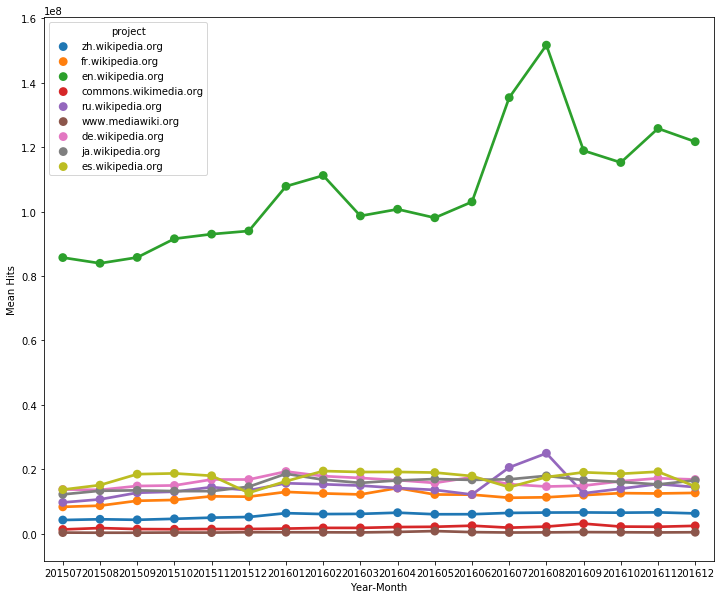

In [33]:
graph_by("project", project_columns)

Look, everyone is hitting English Wikipedia project more than any other project. Also, Russian Wikipedia is having same hike near to august 2016 as English Wikipedia. 

Now with English project in graph, it is hard to visualise other projects. Why not separate out English project and find some patterns if possible.

In [ ]:
graph_by("project", [x for i,x in enumerate(project_columns) if i!=2])

People rarely use mediawiki, commons or  zh. 

Quick check for access and agents as well

In [ ]:
graph_by("access", access_columns)

/usr/local/Cellar/ipython@5/5.5.0_1/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)



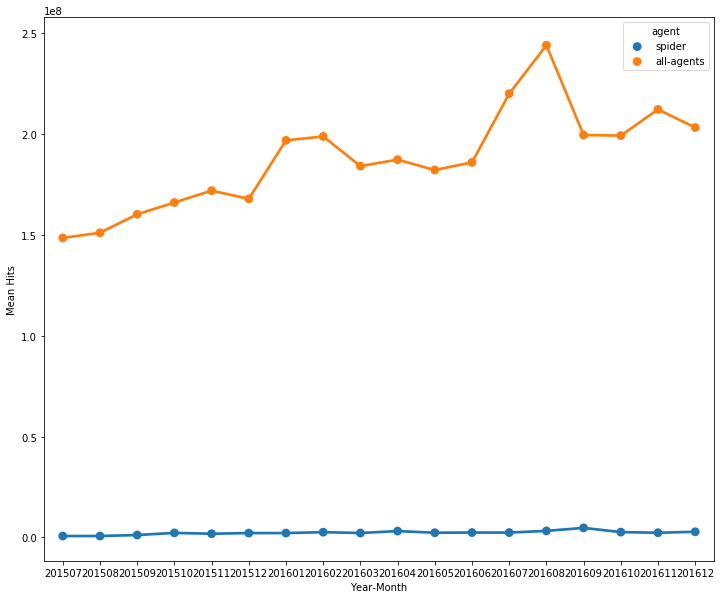

In [35]:
graph_by("agent", agents_columns)

We could not get data pattern from above graph. With just two values for agent why not get them plotted in two separate graphs and see how they behave.

/usr/local/Cellar/ipython@5/5.5.0_1/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)



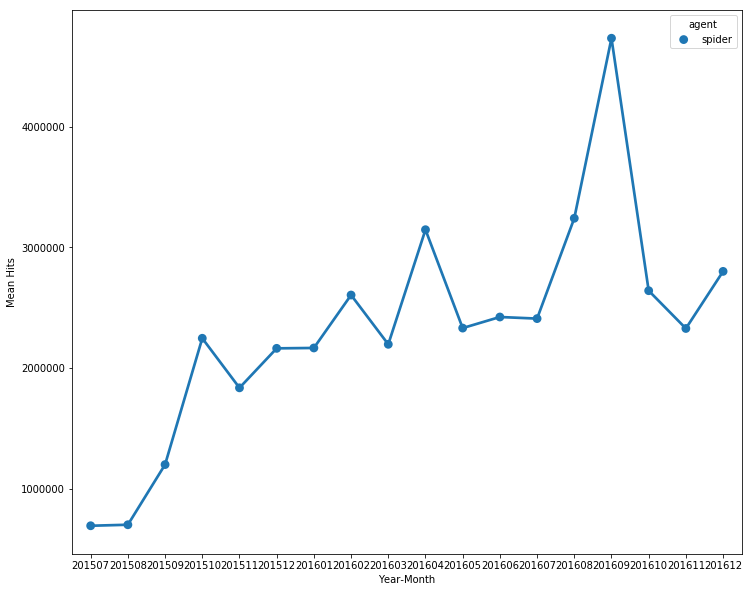

In [34]:
graph_by("agent", agents_columns[0])

In [ ]:
graph_by("agent", agents_columns[1])

Lately observed, all-access and all-agents value for access and agents are summation of values for respective attributes. So each value other than all-access contribute in trend for all-access and all values other than all-agents contribute in trend of all-agents.

To be continued...